## Модуль измерителя сигналов КРЛ и АРС

Структурная схема модуля приведена на рис. 1. 

Модуль измерителя сигналов КРЛ и АРС реализован программно, в процессоре В
приемогенератора ГКС2.

Измерение уровня сигнала КРЛ производится программно при помощи тракта приема АМ сигнала,
использованного в приемнике сигналов КРЛ ТРЦ-3.


Измерение уровня сигналов АРС производится при помощи анализатора спектра
выходного сигнала настроенного на частоты 75,125,175,225,275,325 Гц. 
Использован алгоритм Герцеля со следующими параметрами:

- частота дискретизации 4 кГц;
- окно измерения 160;
- бины {3,5,7,9,11,13}.

Реализация измерителя спектра для сигналов АРС приведена ниже.

In [ ]:
import math
import numpy as np
import const as c


class spectr_analyzer(object):
    def __init__(self):
        """initialization"""
        self.WINDOW_SIZE = 160
        self.BINS = {3,5,7,9,11,13}
        self.SAMPLE_RATE = c.fs
        self._data = [0] * self.WINDOW_SIZE
        self.index = self.WINDOW_SIZE
        self.results = [0]*6
        self.freqs = [0]*6
        self.f_step_normalized = 1.0 / self.WINDOW_SIZE

    def proc(self,sample):

        if self.index == 160:
            self._data.append(sample)
            self.index = 0

            filt_signal = []
            for i in range (self.WINDOW_SIZE):
                multiplier = 0.5 * (1 - np.cos(2*np.pi*i/self.WINDOW_SIZE))
                x = multiplier * self._data[i]
                filt_signal.append(x)

            # For all the bins, calculate the DFT term
            n_range = range(0, self.WINDOW_SIZE)
            N = 0
            for k in self.BINS:
                # Bin frequency and coefficients for the computation
                f = k * self.f_step_normalized
                w_real = 2.0 * math.cos(2.0 * math.pi * f)
                w_imag = math.sin(2.0 * math.pi * f)
                # Doing the calculation on the whole sample
                d1, d2 = 0.0, 0.0
                for n in n_range:
                    y  = filt_signal[n] + w_real * d1 - d2
                    d2, d1 = d1, y
                    # Storing results `(real part, imag part, power)`
                self.results[N] = int((d2**2 + d1**2 - w_real * d1 * d2)/1000000)
                self.freqs[N] = int(f * c.fs)
                N+=1

            return self.freqs, self.results

        else:
            self._data[self.index] = sample
            self.index += 1

            return self.freqs, self.results

Входной сигнал на измерителе представляет собой смесь следующих сигналов:

In [4]:
from krl_rec import *
from white_noise_gen import *
from sig_gen import *


krl_gen = gen(565, 1 * 1024, 8)    # "свой" сигнал КРЛ на частоте 565 Гц


#-Interference-------------------------------
krl_gen = gen(480, 0.5 * 1024, 12)  # помеха на частоте сигнала КРЛ 480 Гц
krl_gen = gen(420, 0.5 * 1024, 8)   # помеха на частоте сигнала КРЛ 420 Гц

ars_gen1 = gen(75, 3 * 1024)   # сигнал АРС 75 Гц, амплитуда 3072 отсчетов
ars_gen2 = gen(125, 0 * 1024)  # сигнал АРС 125 Гц, амплитуда 0 отсчетов
ars_gen3 = gen(175, 1 * 1024)  # сигнал АРС 175 Гц, амплитуда 1024 отсчетов
ars_gen4 = gen(225, 0 * 1024)  # сигнал АРС 225 Гц, амплитуда 0 отсчетов
ars_gen5 = gen(275, 2 * 1024)  # сигнал АРС 275 Гц, амплитуда 2048 отсчетов
ars_gen6 = gen(325, 0 * 1024)  # сигнал АРС 325 Гц, амплитуда 0 отсчетов

noise_gen = white_noise(0.1 * 1024)  # сигнал "белого шума", амплитуда 100 отсчетов

В данном случае, целью является измерение уровня сигналов АРС с частотами 75, 175, 275 Гц 
и контроль отсутствия сигналов АРС на других частотах. Также измеряется сигнал КРЛ с частотой
565 Гц, частота модуляции 8 Гц.


результат работы приведен на рис. 2

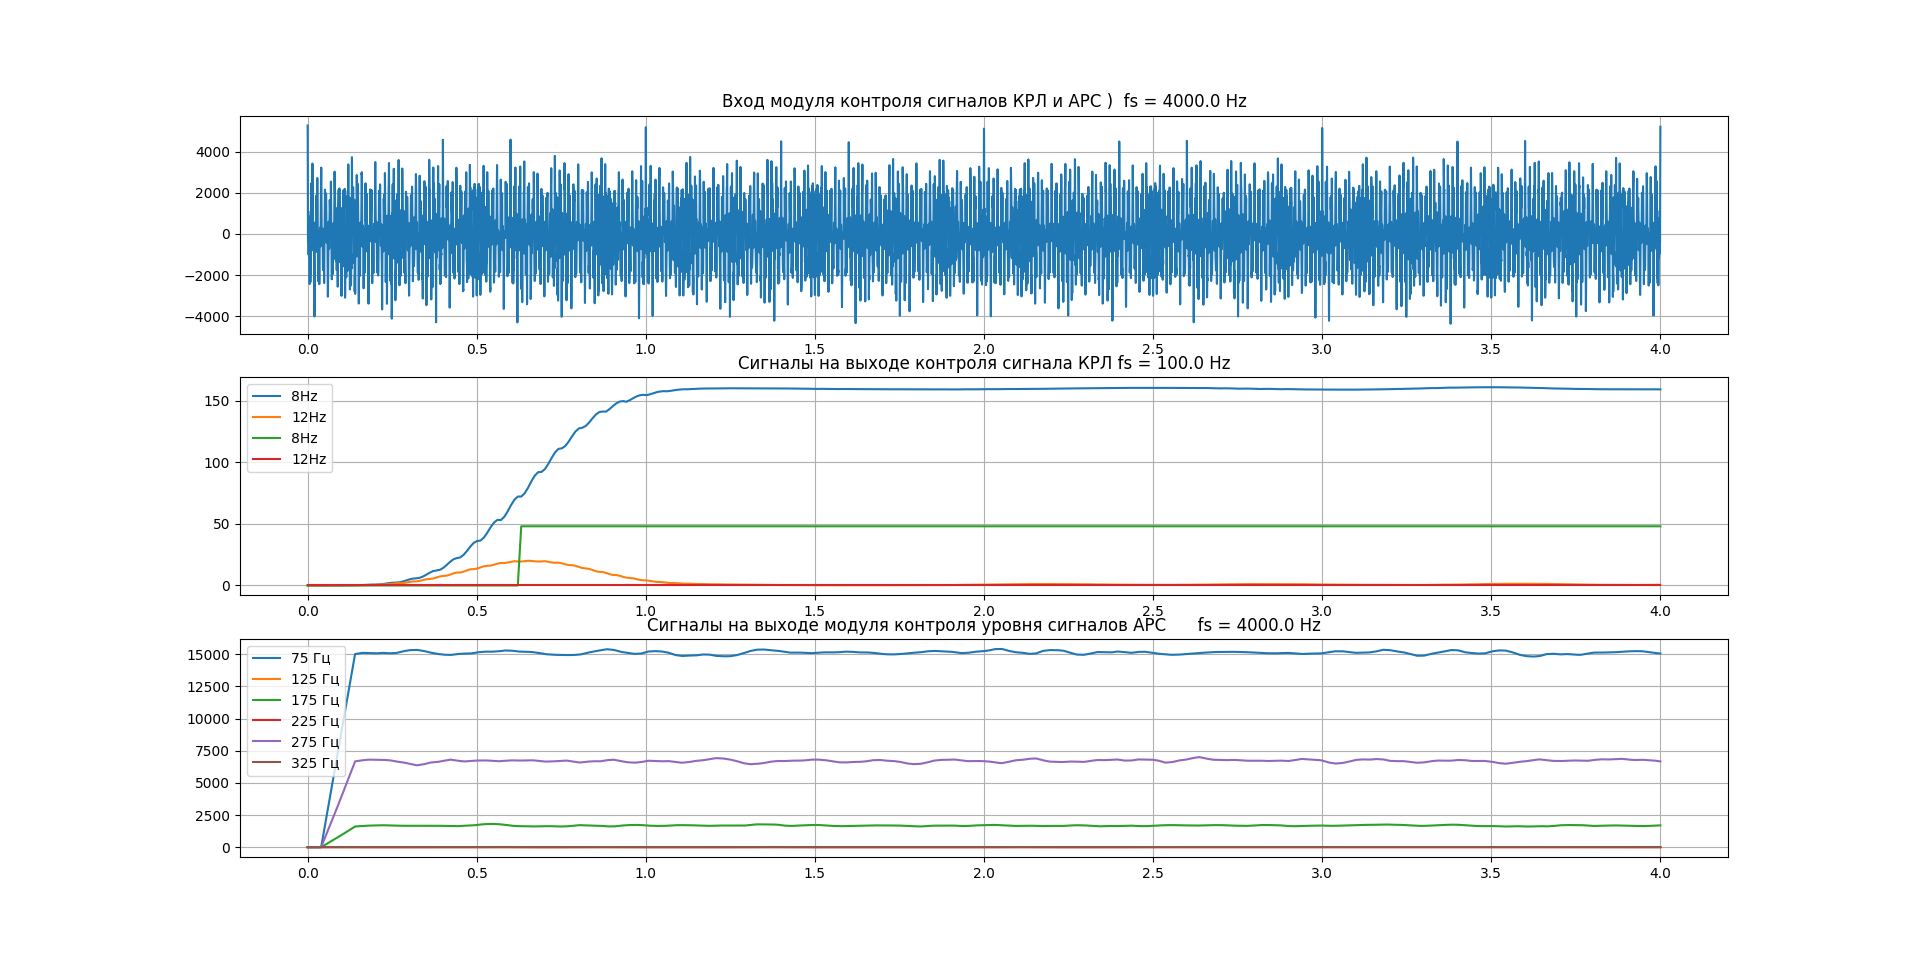

нестабильность уровня измеренного сигнала АРС, на фоне помех, не превышает плюс минус 7%.

Ниже приведен код модели модуля измерения параметров сигналов КРЛ и АРС.

preparing signals

fs = 4000.0 Hz
fs2 = 100.0 Hz
start calculaton model

--- 34.6998074054718 seconds -end preparing--
start plotting model


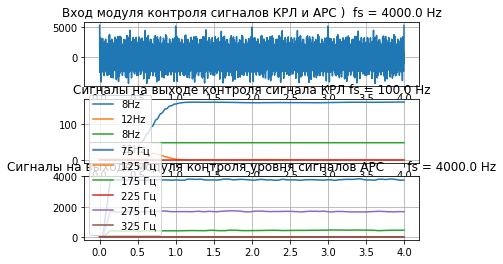

In [1]:
import time
import matplotlib.pyplot as plt
from krl_rec import *
from white_noise_gen import *
from plot2 import *
from sig_gen import *
from am_det import *
from spectr_analyzer import *
import const as c
import sys

#sys.stderr = open('./err.txt', 'w')

start_time = time.time()
print("preparing signals")
#-Start Model config----------------------------

out_buffers = []
[out_buffers.append([]) for i in range(18)]

#-Track line circuit---------------------------
krl_rec = krl_receiver(565, 8)  # rec krl signal
krl_gen = gen(565, 1 * 1024, 8)  # gen krl signal 48 mV (ADC 3.3 V, 16 Bit)

#-Interference-------------------------------
krl_gen = gen(480, 0.5 * 1024, 12)  # gen krl signal 2
krl_gen = gen(420, 0.5 * 1024, 8)  # gen krl signal 3

ars_gen1 = gen(75, 3 * 1024)  # gen ars signal 1
ars_gen2 = gen(125, 0 * 1024)  # gen ars signal 2
ars_gen3 = gen(175, 1 * 1024)  # gen ars signal 3
ars_gen4 = gen(225, 0 * 1024)  # gen ars signal 4
ars_gen5 = gen(275, 2 * 1024)  # gen ars signal 5
ars_gen6 = gen(325, 0 * 1024)  # gen ars signal 6

noise_gen = white_noise(0.1 * 1024)  # gen noise signal (50 mV)

print("")
#-End Model config----------------------------
print("fs = " + str(fs) + " Hz")
print("fs2 = " + str(fs2) + " Hz")

#-Start Main loop------------------------------
print("start calculaton model")
COUNT_DECIM = 0
for i in range(sim_point):

    #-----main-cycle--------------------------------
    COUNT_DECIM += 1

    y_0, y_90 = krl_rec.am_det_inp.mux(c.inp_signal_buff[i])
    out_buffers[0].append(c.inp_signal_buff[i])

    f_ars, u_ars = krl_rec.s_a.proc(c.inp_signal_buff[i])
    
    u_ars75 = krl_rec.filt_ars75.proc(u_ars[0])
    u_ars125 = krl_rec.filt_ars125.proc(u_ars[1])
    u_ars175 = krl_rec.filt_ars175.proc(u_ars[2])
    u_ars225 = krl_rec.filt_ars225.proc(u_ars[3])
    u_ars275 = krl_rec.filt_ars275.proc(u_ars[4])
    u_ars325 = krl_rec.filt_ars325.proc(u_ars[5])

    out_buffers[1].append(u_ars75)
    out_buffers[2].append(u_ars125)
    out_buffers[3].append(u_ars175)
    out_buffers[4].append(u_ars225)
    out_buffers[5].append(u_ars275)
    out_buffers[6].append(u_ars325)

    if COUNT_DECIM == c.dec_coef:  # fs = 100
        y_dem = krl_rec.am_det_inp.demod(y_0, y_90)  # signal after demodulator

        y_det_filt = krl_rec.filt_det.proc(y_dem)

        y_f8Hz = krl_rec.hz8_fir.proc(y_dem)
        y_f12Hz = krl_rec.hz12_fir.proc(y_dem)

        y_ask_det8 = krl_rec.am_det8.proc(y_f8Hz)
        y_ask_det12 = krl_rec.am_det12.proc(y_f12Hz)

        y_f8 = krl_rec.filt_8hz.proc(y_ask_det8)
        y_f12 = krl_rec.filt_12hz.proc(y_ask_det12)
        out_buffers[11].append(y_f8)
        out_buffers[12].append(y_f12)

        y_comp8 = krl_rec.comp8.proc(y_f8)
        y_comp12 = krl_rec.comp12.proc(y_f12)
        out_buffers[13].append(y_comp8)
        out_buffers[14].append(y_comp12)

        COUNT_DECIM = 0

#-End Main loop---------------------------------

#-----plot-results------------------------------

#for i in range (10):
#    print(len(out_buffers[i]))
print ("")
print("--- %s seconds -end preparing--" % (time.time() - start_time))
print("start plotting model")
to_plot(out_buffers, c.inp_signal_buff)

#plotSpectrum(c.inp_signal_buff)

plt.show()